# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig0850s2"   # Used for tflite Filename
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 400

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '/*.jpg')
    if aktsubdir == "NaN":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        x_data.append(test_image)
        y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1100, 32, 20, 3)
(1100, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 32)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)



Epoch 1/400
275/275 [==============================] - 3s 6ms/step - loss: 2.1596 - accuracy: 0.3475
Epoch 2/400
275/275 [==============================] - 2s 6ms/step - loss: 1.4983 - accuracy: 0.5077
Epoch 3/400
275/275 [==============================] - 2s 6ms/step - loss: 1.0442 - accuracy: 0.6730
Epoch 4/400
275/275 [==============================] - 2s 7ms/step - loss: 0.8246 - accuracy: 0.7112
Epoch 5/400
275/275 [==============================] - 2s 7ms/step - loss: 0.7863 - accuracy: 0.7734: 0s - loss: 0.7970 - accura
Epoch 6/400
275/275 [==============================] - 2s 9ms/step - loss: 0.5979 - accuracy: 0.8116
Epoch 7/400
275/275 [==============================] - 2s 8ms/step - loss: 0.5112 - accuracy: 0.8225
Epoch 8/400
275/275 [==============================] - 2s 8ms/step - loss: 0.5652 - accuracy: 0.8288
Epoch 9/400
275/275 [==============================] - 2s 8ms/step - loss: 0.4903 - accuracy: 0.8440
Epoch 10/400
275/275 [==============================] - 2s 8ms/

275/275 [==============================] - 3s 12ms/step - loss: 0.1311 - accuracy: 0.9673
Epoch 81/400
275/275 [==============================] - 3s 11ms/step - loss: 0.0796 - accuracy: 0.9792
Epoch 82/400
275/275 [==============================] - 3s 10ms/step - loss: 0.0978 - accuracy: 0.9778
Epoch 83/400
275/275 [==============================] - 3s 10ms/step - loss: 0.0827 - accuracy: 0.9714
Epoch 84/400
275/275 [==============================] - 3s 11ms/step - loss: 0.0859 - accuracy: 0.9711
Epoch 85/400
275/275 [==============================] - 3s 12ms/step - loss: 0.1561 - accuracy: 0.9515
Epoch 86/400
275/275 [==============================] - 3s 11ms/step - loss: 0.0893 - accuracy: 0.9731
Epoch 87/400
275/275 [==============================] - 3s 10ms/step - loss: 0.1119 - accuracy: 0.9725
Epoch 88/400
275/275 [==============================] - 3s 11ms/step - loss: 0.0829 - accuracy: 0.9697
Epoch 89/400
275/275 [==============================] - 3s 10ms/step - loss: 0.0961 - 

275/275 [==============================] - 3s 10ms/step - loss: 0.0430 - accuracy: 0.9841
Epoch 159/400
275/275 [==============================] - 3s 10ms/step - loss: 0.0382 - accuracy: 0.9795
Epoch 160/400
275/275 [==============================] - 3s 10ms/step - loss: 0.0742 - accuracy: 0.9773
Epoch 161/400
275/275 [==============================] - 3s 10ms/step - loss: 0.0579 - accuracy: 0.9882
Epoch 162/400
275/275 [==============================] - 3s 11ms/step - loss: 0.0364 - accuracy: 0.9884
Epoch 163/400
275/275 [==============================] - 3s 10ms/step - loss: 0.0700 - accuracy: 0.9760
Epoch 164/400
275/275 [==============================] - 3s 10ms/step - loss: 0.0576 - accuracy: 0.9855
Epoch 165/400
275/275 [==============================] - 3s 10ms/step - loss: 0.0709 - accuracy: 0.9830
Epoch 166/400
275/275 [==============================] - 3s 10ms/step - loss: 0.0386 - accuracy: 0.9874
Epoch 167/400
275/275 [==============================] - 3s 11ms/step - loss: 

275/275 [==============================] - 3s 11ms/step - loss: 0.0589 - accuracy: 0.9882
Epoch 236/400
275/275 [==============================] - 3s 11ms/step - loss: 0.0593 - accuracy: 0.9778
Epoch 237/400
275/275 [==============================] - 3s 12ms/step - loss: 0.0669 - accuracy: 0.9863
Epoch 238/400
275/275 [==============================] - 4s 15ms/step - loss: 0.0430 - accuracy: 0.9887
Epoch 239/400
275/275 [==============================] - 4s 14ms/step - loss: 0.0554 - accuracy: 0.9868
Epoch 240/400
275/275 [==============================] - 3s 12ms/step - loss: 0.0689 - accuracy: 0.9799
Epoch 241/400
275/275 [==============================] - 4s 13ms/step - loss: 0.0419 - accuracy: 0.9855
Epoch 242/400
275/275 [==============================] - 4s 13ms/step - loss: 0.0651 - accuracy: 0.9878
Epoch 243/400
275/275 [==============================] - 3s 12ms/step - loss: 0.0538 - accuracy: 0.9811
Epoch 244/400
275/275 [==============================] - 3s 11ms/step - loss: 

275/275 [==============================] - 3s 10ms/step - loss: 0.0168 - accuracy: 0.9923
Epoch 314/400
275/275 [==============================] - 3s 11ms/step - loss: 0.0348 - accuracy: 0.9863
Epoch 315/400
275/275 [==============================] - 3s 11ms/step - loss: 0.0325 - accuracy: 0.9950
Epoch 316/400
275/275 [==============================] - 3s 10ms/step - loss: 0.0676 - accuracy: 0.9853
Epoch 317/400
275/275 [==============================] - 3s 12ms/step - loss: 0.0265 - accuracy: 0.9960
Epoch 318/400
275/275 [==============================] - 3s 12ms/step - loss: 0.0343 - accuracy: 0.9871
Epoch 319/400
275/275 [==============================] - 3s 12ms/step - loss: 0.0352 - accuracy: 0.9913
Epoch 320/400
275/275 [==============================] - 3s 12ms/step - loss: 0.0120 - accuracy: 0.9953
Epoch 321/400
275/275 [==============================] - 3s 12ms/step - loss: 0.0762 - accuracy: 0.9879
Epoch 322/400
275/275 [==============================] - 3s 12ms/step - loss: 

275/275 [==============================] - 3s 11ms/step - loss: 0.0629 - accuracy: 0.9888
Epoch 392/400
275/275 [==============================] - 3s 11ms/step - loss: 0.0339 - accuracy: 0.9918
Epoch 393/400
275/275 [==============================] - 3s 11ms/step - loss: 0.0118 - accuracy: 0.9961
Epoch 394/400
275/275 [==============================] - 3s 11ms/step - loss: 0.0322 - accuracy: 0.9931
Epoch 395/400
275/275 [==============================] - 3s 11ms/step - loss: 0.0180 - accuracy: 0.9951
Epoch 396/400
275/275 [==============================] - 3s 11ms/step - loss: 0.0179 - accuracy: 0.9950
Epoch 397/400
275/275 [==============================] - 3s 12ms/step - loss: 0.0289 - accuracy: 0.9930
Epoch 398/400
275/275 [==============================] - 3s 12ms/step - loss: 0.0293 - accuracy: 0.9952
Epoch 399/400
275/275 [==============================] - 3s 11ms/step - loss: 0.0355 - accuracy: 0.9908
Epoch 400/400
275/275 [==============================] - 3s 12ms/step - loss: 

### Learing result
 
* Visualization of the training and validation results

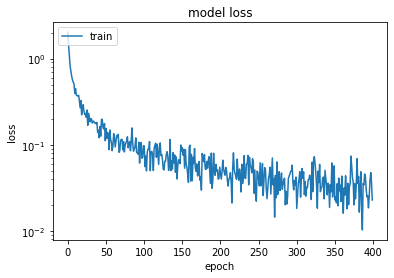

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

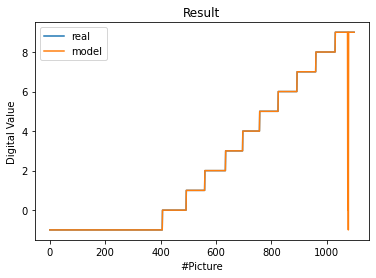

In [6]:
Input_dir='ziffer_sortiert_resize'
subdir = ["NaN", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
res = []

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    if aktsubdir == "NaN":
        zw1 = -1
    else:
        zw1 = int(aktsubdir)
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = np.argmax(model.predict(img), axis=-1)
        classes = classes[0]
        if classes == 10: 
            classes = -1
        zw2 = classes
        zw3 = zw2 - zw1
        res.append(np.array([zw1, zw2, zw3]))

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpyip92okm\assets


356604

In [8]:
FileName = TFliteNamingAndVersion + "q"

import tensorflow as tf

def representative_dataset():
    for _ in range(500):
      data = np.random.rand(1, 32, 20, 3) * 255
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName + ".tflite", "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp9dtc1x0r\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp9dtc1x0r\assets


98512

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


In [9]:
Input_dir='ziffer_sortiert_resize'
only_deviation = True

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    expected_class = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = np.argmax(model.predict(img), axis=-1)
        classes = classes[0]
        if classes == 10: 
            classes = "NaN"
        if only_deviation == True:
            if str(classes) != str(expected_class):
                print(aktfile + " " + aktsubdir +  " " + str(classes))
        else:
            print(aktfile + " " + aktsubdir +  " " + str(classes))


ziffer_sortiert_resize/9\D6_2020-08-12_15-09-41.jpg 9 0
ziffer_sortiert_resize/9\D8_2020-08-20_11-32-19.jpg 9 NaN


Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.